Training agent...


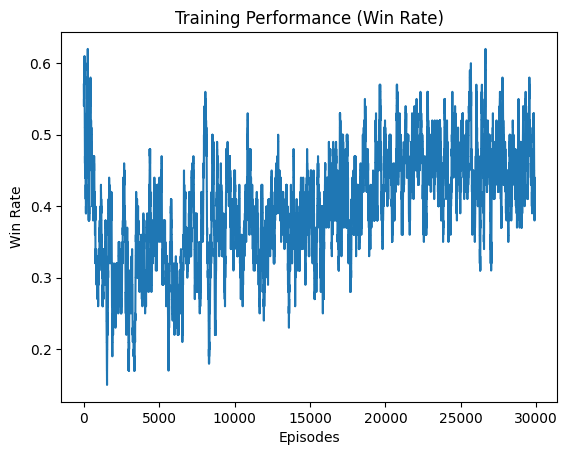


Play against AI (You are O)
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
| X |   |   | 
-------------
Enter row (0-2): 1
Enter col (0-2): 2
-------------
|   |   |   | 
-------------
|   |   | O | 
-------------
| X |   | X | 
-------------
Enter row (0-2): 2
Enter col (0-2): 2
Enter row (0-2): 2
Enter col (0-2): 0
Enter row (0-2): 2
Enter col (0-2): 1
-------------
|   |   |   | 
-------------
|   | X | O | 
-------------
| X | O | X | 
-------------
Enter row (0-2): 1
Enter col (0-2): 2
Enter row (0-2): 0
Enter col (0-2): 1
-------------
| X | O |   | 
-------------
|   | X | O | 
-------------
| X | O | X | 
-------------
Computer wins!


In [ ]:
# -*- coding: utf-8 -*-
# Tic Tac Toe
"""
Tic Tac Toe using Reinforcement Learning
Training + Human Play Version
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt

BOARD_ROWS = 3
BOARD_COLS = 3


class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        self.playerSymbol = 1

    def getHash(self):
        self.boardHash = str(self.board.reshape(9))
        return self.boardHash

    def availablePositions(self):
        return [(i, j) for i in range(BOARD_ROWS)
                for j in range(BOARD_COLS) if self.board[i, j] == 0]

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    def winner(self):
        for i in range(BOARD_ROWS):
            if abs(sum(self.board[i, :])) == 3:
                self.isEnd = True
                return np.sign(sum(self.board[i, :]))

        for i in range(BOARD_COLS):
            if abs(sum(self.board[:, i])) == 3:
                self.isEnd = True
                return np.sign(sum(self.board[:, i]))

        diag1 = sum(self.board[i, i] for i in range(BOARD_ROWS))
        diag2 = sum(self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_ROWS))
        if abs(diag1) == 3 or abs(diag2) == 3:
            self.isEnd = True
            return np.sign(diag1 + diag2)

        if not self.availablePositions():
            self.isEnd = True
            return 0

        return None

    def giveReward(self):
        result = self.winner()
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.5)
            self.p2.feedReward(0.5)

    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def showBoard(self):
        for i in range(BOARD_ROWS):
            print("-------------")
            row = "| "
            for j in range(BOARD_COLS):
                if self.board[i, j] == 1:
                    row += "X | "
                elif self.board[i, j] == -1:
                    row += "O | "
                else:
                    row += "  | "
            print(row)
        print("-------------")

    # ---------------- TRAIN ----------------
    def train(self, rounds=30000):
        win_rate = []

        for i in range(rounds):
            while not self.isEnd:
                p1_action = self.p1.chooseAction(
                    self.availablePositions(), self.board, self.playerSymbol)
                self.updateState(p1_action)
                self.p1.addState(self.getHash())

                win = self.winner()
                if win is not None:
                    self.giveReward()
                    win_rate.append(1 if win == 1 else 0)
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                p2_action = self.p2.chooseAction(
                    self.availablePositions(), self.board, self.playerSymbol)
                self.updateState(p2_action)
                self.p2.addState(self.getHash())

                win = self.winner()
                if win is not None:
                    self.giveReward()
                    win_rate.append(1 if win == 1 else 0)
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

            self.p1.decayEpsilon()

        return win_rate

    # ---------------- HUMAN PLAY ----------------
    def playHuman(self):
        while not self.isEnd:
            if self.playerSymbol == 1:
                action = self.p1.chooseAction(
                    self.availablePositions(), self.board, self.playerSymbol)
            else:
                self.showBoard()
                while True:
                    row = int(input("Enter row (0-2): "))
                    col = int(input("Enter col (0-2): "))
                    if (row, col) in self.availablePositions():
                        action = (row, col)
                        break

            self.updateState(action)
            win = self.winner()

            if win is not None:
                self.showBoard()
                if win == 1:
                    print("Computer wins!")
                elif win == -1:
                    print("You win!")
                else:
                    print("It's a tie!")
                self.reset()
                break


class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}

    def chooseAction(self, positions, board, symbol):
        if np.random.rand() <= self.exp_rate:
            return positions[np.random.choice(len(positions))]
        value_max = -999
        action = None
        for p in positions:
            next_board = board.copy()
            next_board[p] = symbol
            value = self.states_value.get(str(next_board.reshape(9)), 0)
            if value >= value_max:
                value_max = value
                action = p
        return action

    def addState(self, state):
        self.states.append(state)

    def feedReward(self, reward):
        for st in reversed(self.states):
            self.states_value[st] = self.states_value.get(st, 0)
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def decayEpsilon(self):
        self.exp_rate = max(0.01, self.exp_rate * 0.995)

    def reset(self):
        self.states = []

    def savePolicy(self):
        with open('policy_' + self.name, 'wb') as f:
            pickle.dump(self.states_value, f)

    def loadPolicy(self, file):
        with open(file, 'rb') as f:
            self.states_value = pickle.load(f)


# ---------------- MAIN ----------------
if __name__ == "__main__":

    # TRAINING
    p1 = Player("p1")
    p2 = Player("p2")

    st = State(p1, p2)
    print("Training agent...")
    win_rate = st.train(30000)
    p1.savePolicy()

    # GRAPH
    plt.plot(np.convolve(win_rate, np.ones(100)/100, mode='valid'))
    plt.title("Training Performance (Win Rate)")
    plt.xlabel("Episodes")
    plt.ylabel("Win Rate")
    plt.show()

    # HUMAN PLAY
    ai = Player("computer", exp_rate=0)
    ai.loadPolicy("policy_p1")

    game = State(ai, None)
    print("\nPlay against AI (You are O)")
    game.playHuman()


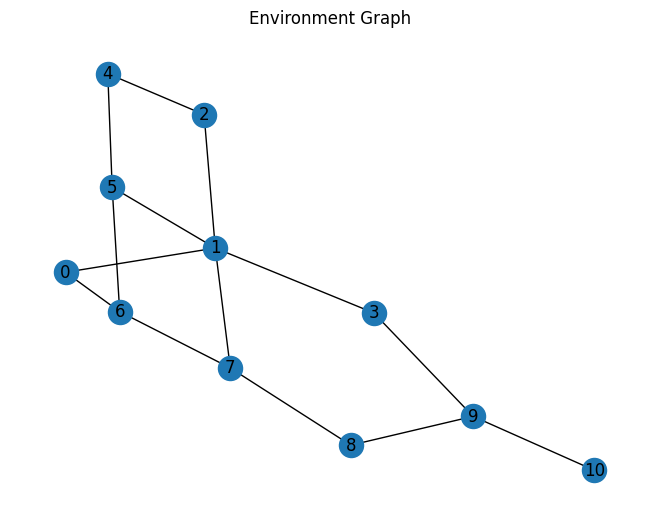

Trained Q-Matrix (normalized):
[[ -1.          42.1875       0.           0.           0.
    0.          31.640625     0.           0.           0.
    0.        ]
 [ 31.640625     0.          31.640625    56.25         0.
   31.640625     0.          42.1875       0.           0.
    0.        ]
 [ -1.          42.1875       0.           0.          23.73046875
    0.           0.           0.           0.           0.
    0.        ]
 [ -1.          42.1875       0.           0.           0.
    0.           0.           0.           0.          75.
    0.        ]
 [ 30.640625     0.          31.640625     0.           0.
   31.640625     0.           0.           0.           0.
    0.        ]
 [ -1.          42.1875       0.           0.          23.73046875
    0.          31.640625     0.           0.           0.
    0.        ]
 [ 31.640625     0.           0.           0.           0.
   31.640625     0.          42.1875       0.           0.
    0.        ]
 [  0.         

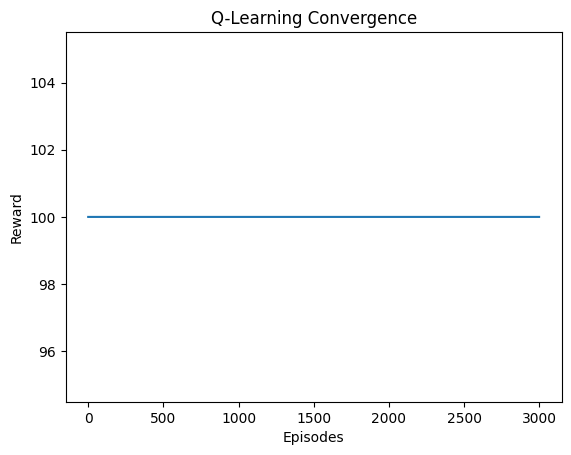

In [ ]:
# -*- coding: utf-8 -*-
# Deep Reinforcement Learning
"""
Deep Reinforcement Learning (Q-learning on Graph)
"""

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ---------------- ENVIRONMENT ----------------
edges = [
    (0, 1), (1, 5), (5, 6), (5, 4), (1, 2),
    (1, 3), (9, 10), (2, 4), (0, 6), (6, 7),
    (8, 9), (7, 8), (1, 7), (3, 9)
]

goal = 10
states = 11
gamma = 0.75
epsilon = 0.7
episodes = 3000

# Graph visualization
G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True)
plt.title("Environment Graph")
plt.show()

# Reward matrix
R = -1 * np.ones((states, states))
for (i, j) in edges:
    R[i, j] = 100 if j == goal else 0
    R[j, i] = 100 if i == goal else 0
R[goal, goal] = 100

# ---------------- AGENT ----------------
Q = np.zeros((states, states))

def available_actions(state):
    return np.where(R[state] >= 0)[0]

def choose_action(state):
    if np.random.rand() < epsilon:
        return np.random.choice(available_actions(state))
    return np.argmax(Q[state])

def update_q(state, action):
    Q[state, action] = R[state, action] + gamma * np.max(Q[action])

# ---------------- TRAINING ----------------
rewards = []

for _ in range(episodes):
    state = np.random.randint(0, states)
    while state != goal:
        action = choose_action(state)
        update_q(state, action)
        state = action
    rewards.append(np.max(Q))

# ---------------- RESULTS ----------------
print("Trained Q-Matrix (normalized):")
print(Q / np.max(Q) * 100)

# Optimal path
state = 0
path = [state]
while state != goal:
    state = np.argmax(Q[state])
    path.append(state)

print("Optimal Path:", path)

# ---------------- GRAPH ----------------
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Q-Learning Convergence")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 5, 64)          │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,125 (59.08 KB)

 Trainable params: 15,125 (59.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.1216 - loss: 2.8898 - val_accuracy: 0.2500 - val_loss: 2.8362
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1794 - loss: 2.7902 - val_accuracy: 0.1667 - val_loss: 2.8176
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2528 - loss: 2.5446 - val_accuracy: 0.1667 - val_loss: 2.8277
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3987 - loss: 2.1881 - val_accuracy: 0.1667 - val_loss: 2.8167
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2912 - loss: 2.1385 - val_accuracy: 0.2500 - val_loss: 2.8375
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5230 - loss: 2.0071 - val_accuracy: 0.2500 - val_loss: 2.8421
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5546 - loss: 1.8420 - val_accuracy: 0.2500 - val_loss: 2.8537
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6887 - loss: 1.7043 - val_accuracy: 0.2500 - val_loss: 2.8667


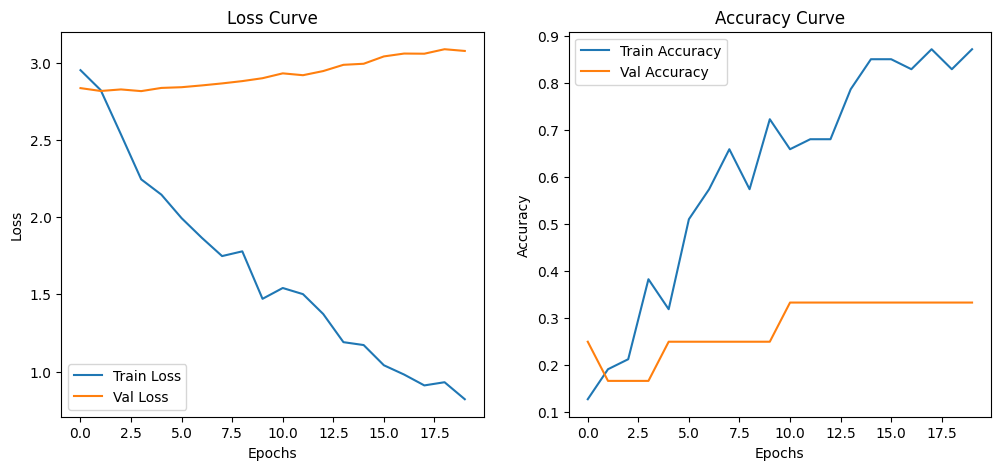


Generated Text:
The beautiiul gsretimul gere anre iimet sasetyiilles  inme 


In [ ]:
# -*- coding: utf-8 -*-
# RNN
"""
Modified RNN Text Generation
Changes:
- Added train/validation split
- Added Dropout for regularization
- Changed optimizer to RMSprop
- Improved model depth
- Added training graphs
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split

# ---------------- DATA ----------------
text = "The beautiful girl whom I met last time is very intelligent also"

chars = sorted(list(set(text)))
char_to_index = {c: i for i, c in enumerate(chars)}
index_to_char = {i: c for i, c in enumerate(chars)}

seq_length = 5
sequences, labels = [], []

for i in range(len(text) - seq_length):
    seq = text[i:i + seq_length]
    label = text[i + seq_length]
    sequences.append([char_to_index[c] for c in seq])
    labels.append(char_to_index[label])

X = np.array(sequences)
y = np.array(labels)

X = tf.one_hot(X, len(chars))
y = tf.one_hot(y, len(chars))

# ---------------- TRAIN / VALIDATION SPLIT ----------------
X_train, X_val, y_train, y_val = train_test_split(
    X.numpy(), y.numpy(), test_size=0.2, random_state=42
)

# ---------------- MODEL ----------------
model = Sequential([
    SimpleRNN(64, activation='tanh',
              input_shape=(seq_length, len(chars)),
              return_sequences=True),
    Dropout(0.3),

    SimpleRNN(64, activation='tanh'),
    Dropout(0.3),

    Dense(len(chars), activation='softmax')
])

# Optimizer changed
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ---------------- TRAINING ----------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8
)

# ---------------- GRAPHS ----------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# ---------------- TEXT GENERATION ----------------
start_seq = "The beaut"
generated_text = start_seq
text_len = 50

for _ in range(text_len):
    input_seq = [char_to_index[c] for c in generated_text[-seq_length:]]
    input_seq = tf.one_hot([input_seq], len(chars))

    prediction = model.predict(input_seq, verbose=0)
    next_char = index_to_char[np.argmax(prediction)]
    generated_text += next_char

print("\nGenerated Text:")
print(generated_text)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,741 (36.49 MB)

 Trainable params: 9,564,741 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.3485 - loss: 1.4648 - val_accuracy: 0.5395 - val_loss: 1.1279
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.5158 - loss: 1.1660 - val_accuracy: 0.5640 - val_loss: 1.0797
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.5762 - loss: 1.0652 - val_accuracy: 0.5817 - val_loss: 1.0354
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.5962 - loss: 1.0197 - val_accuracy: 0.6471 - val_loss: 0.9423
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6384 - loss: 0.9444 - val_accuracy: 0.6649 - val_loss: 0.8933
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6623 - loss: 0.8877 - val_accuracy: 0.6567 - val_loss: 0.9021
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6763 - loss: 0.8513 - val_accuracy: 0.6485 - val_loss: 0.8808
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6936 - loss: 0.7912 - val_accuracy: 0.6935 - v

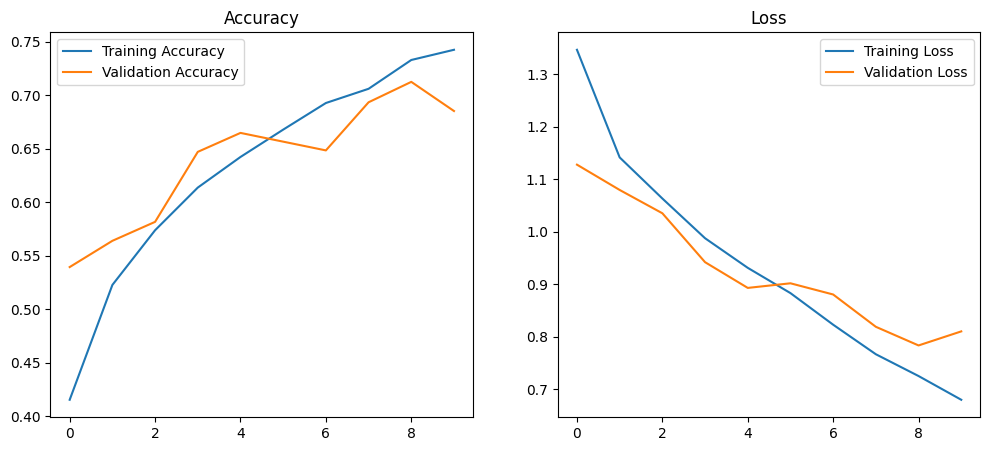

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


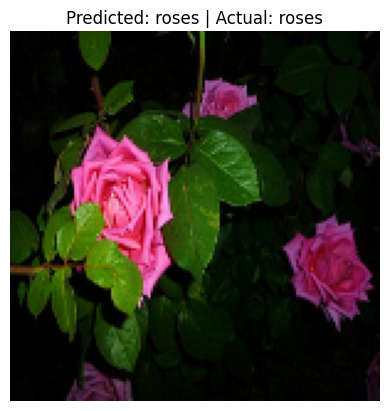

In [6]:
# -*- coding: utf-8 -*-
# catDog
"""
CNN Image Classification using TF Flowers Dataset
Auto-download using TensorFlow Datasets
"""

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# ---------------- LOAD DATASET ----------------
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

# ---------------- PREPROCESSING ----------------
IMG_SIZE = 150
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE)

# ---------------- MODEL ----------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model.summary()

# ---------------- COMPILE ----------------
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------- TRAIN ----------------
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

# ---------------- GRAPHS ----------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# ---------------- SINGLE IMAGE PREDICTION ----------------
import matplotlib.pyplot as plt

for image, label in val_ds.take(1):
    test_image = image[0]
    true_label = label[0]

test_image_exp = tf.expand_dims(test_image, axis=0)
prediction = model.predict(test_image_exp)
predicted_class = np.argmax(prediction)

plt.imshow(test_image)
plt.axis('off')
plt.title(
    f"Predicted: {class_names[predicted_class]} | Actual: {class_names[int(true_label)]}"
)
plt.show()


In [2]:
# -*- coding: utf-8 -*-
# AlexNet
"""
Character Level Text Generation using SimpleRNN
Improved & Correct Version
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# ---------------- INPUT TEXT ----------------
text = "The beautiful girl whom I met last time is very intelligent also "

# ---------------- CHARACTER MAPPING ----------------
chars = sorted(list(set(text)))
char_to_index = {c: i for i, c in enumerate(chars)}
index_to_char = {i: c for i, c in enumerate(chars)}

vocab_size = len(chars)
seq_length = 10

# ---------------- CREATE DATASET ----------------
sequences = []
labels = []

for i in range(len(text) - seq_length):
    sequences.append([char_to_index[c] for c in text[i:i+seq_length]])
    labels.append(char_to_index[text[i+seq_length]])

X = np.array(sequences)
y = np.array(labels)

X = tf.one_hot(X, vocab_size)
y = tf.one_hot(y, vocab_size)

# ---------------- MODEL ----------------
model = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(seq_length, vocab_size)),
    Dense(vocab_size, activation='softmax')
])

model.summary()

# ---------------- COMPILE ----------------
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------- TRAIN ----------------
model.fit(X, y, epochs=150, batch_size=16)

# ---------------- TEMPERATURE SAMPLING FUNCTION ----------------
def sample(preds, temperature=0.8):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

# ---------------- TEXT GENERATION ----------------
start_seq = "The beautiful"
generated = start_seq

print("\nGenerated Text:\n")

for _ in range(100):
    input_seq = [char_to_index[c] for c in generated[-seq_length:]]
    input_seq = tf.one_hot([input_seq], vocab_size)

    preds = model.predict(input_seq, verbose=0)[0]
    next_index = sample(preds, temperature=0.7)
    next_char = index_to_char[next_index]

    generated += next_char

print(generated)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,909 (85.58 KB)

 Trainable params: 21,909 (85.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0291 - loss: 3.1241  
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1873 - loss: 2.7734
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3226 - loss: 2.4410
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3559 - loss: 2.2167
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5775 - loss: 1.9766
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6399 - loss: 1.7686
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7253 - loss: 1.5945
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8012 - loss: 1.3249 
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8803 - loss: 1.2409
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9771 - loss: 1.0070
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9282 - loss: 0.9146
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9813 -

Dataset Loaded Successfully


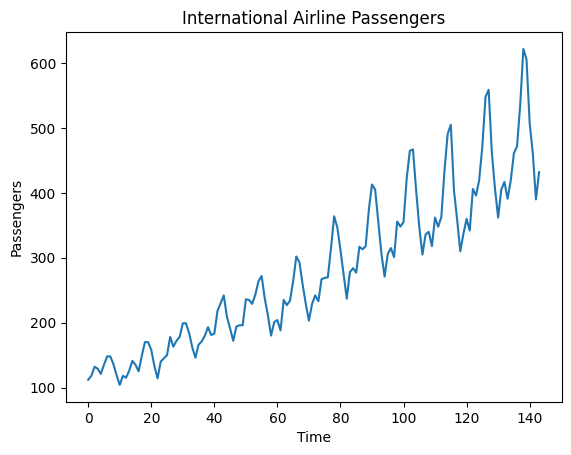

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,251 (47.86 KB)

 Trainable params: 12,251 (47.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0487
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038
Epoch 11/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 12/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 13/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 14/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 15/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 16/50
97/97 ━

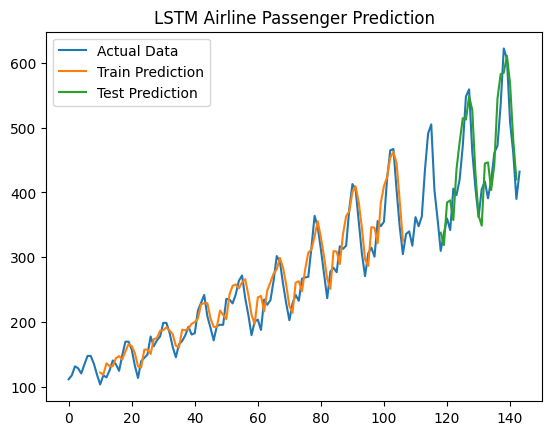

In [10]:
# -*- coding: utf-8 -*-
# LSTM Airline Passenger Prediction
"""
Created on Wed Nov  5 08:42:47 2025

@author: USER
"""

# --------- IMPORT LIBRARIES ---------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --------- DOWNLOAD DATASET ---------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)
data.columns = ["Month", "Passengers"]

print("Dataset Loaded Successfully")
data.head()

# --------- PREPARE DATA ---------
dataset = data["Passengers"].values.astype("float32")
dataset = dataset.reshape(-1, 1)

# --------- VISUALIZATION ---------
plt.plot(dataset)
plt.title("International Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.show()

# --------- NORMALIZATION ---------
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# --------- TRAIN TEST SPLIT ---------
train_size = int(len(dataset) * 0.75)
train = dataset[:train_size]
test = dataset[train_size:]

# --------- CREATE TIME SERIES DATA ---------
def create_dataset(data, time_step=10):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10

trainX, trainY = create_dataset(train, time_step)
testX, testY = create_dataset(test, time_step)

# --------- RESHAPE FOR LSTM ---------
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

# --------- MODEL ---------
model = Sequential([
    LSTM(50, input_shape=(1, time_step)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --------- TRAIN MODEL ---------
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

# --------- PREDICTION ---------
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# --------- INVERSE SCALING ---------
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# --------- RMSE ---------
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print(f"Train RMSE: {trainScore:.2f}")
print(f"Test RMSE : {testScore:.2f}")

# --------- PLOTTING RESULTS ---------
trainPlot = np.empty_like(dataset)
trainPlot[:] = np.nan
trainPlot[time_step:len(trainPredict) + time_step] = trainPredict

testPlot = np.empty_like(dataset)
testPlot[:] = np.nan
testPlot[len(trainPredict) + (time_step * 2) + 1:len(dataset) - 1] = testPredict

plt.plot(scaler.inverse_transform(dataset), label="Actual Data")
plt.plot(trainPlot, label="Train Prediction")
plt.plot(testPlot, label="Test Prediction")
plt.legend()
plt.title("LSTM Airline Passenger Prediction")
plt.show()
